In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("https://github.com/AllenDowney/ThinkBayes2/blob/master/data/drp_scores.csv?raw=true",
                skiprows=21, delimiter="\t")
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


In [4]:
# We use groupby to separate the data by Treated and Ctrl groups

grouped = df.groupby("Treatment")
responses = {}

for name, group in grouped:
    responses[name] = group["Response"]

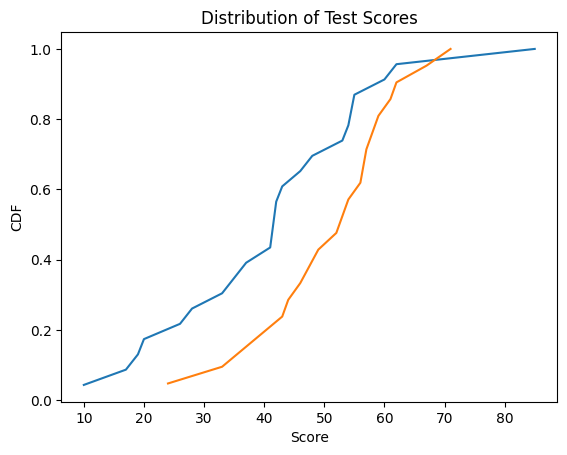

In [5]:
# Plot CDFs of the 2 groups

from empiricaldist import Cdf

for name, response in responses.items():
    cdf = Cdf.from_seq(response)
    cdf.plot(label=name)
    plt.xlabel("Score")
    plt.ylabel("CDF")
    plt.title("Distribution of Test Scores")
    
# We'll assume that the distributions of scores are well-modeled by a normal distribution

In [6]:
# As always we need a prior for the unknown mean and SD parameters; because there are 2 this will be a joint dist
# To start we'll assume uniform priors for mu and sigma

from empiricaldist import Pmf

def make_uniform(qs, name=None, **options):
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [7]:
qs = np.linspace(20, 80, num=101) # bounds chosen by trial and error
prior_mu = make_uniform(qs, name='mean')

In [8]:
qs = np.linspace(5, 30, num=101)
prior_sigma = make_uniform(qs, name='std')

In [9]:
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [10]:
prior = make_joint(prior_mu, prior_sigma)

In [11]:
# Start by working with data from the control group

data = responses["Control"]
data.shape

(23,)

In [12]:
# Next we compute the likelihood of the data for each pair of parameters in the distribution
# Start by making a 3D grid with values of mu, sigma, and the data on each axis

mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
mu_mesh.shape

(101, 101, 23)

In [13]:
from scipy.stats import norm

In [14]:
densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

In [15]:
# To compute likelihoods, we multiply the densities along axis=2 (the data axis)

likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

In [16]:
def normalize(joint):
    """Normalize a joint distribution."""
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [17]:
posterior = prior * likelihood
normalize(posterior)
posterior.shape

(101, 101)

In [18]:
# The above steps can be encapsulated in a function

def update_norm(prior, data):
    """Update the joint prior with the data"""
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)
    posterior = prior * likelihood
    normalize(posterior)
    
    return posterior

In [19]:
data = responses["Control"]
posterior_control = update_norm(prior, data)

In [20]:
data = responses["Treated"]
posterior_treated = update_norm(prior, data)

In [25]:
def plot_contour(joint, cmap):
    """Plot a joint distribution with a contour."""
    plt.contour(joint.columns, joint.index, joint,
                linewidths=2)

Text(0.5, 1.0, 'Joint posterior distributions of mu and sigma')

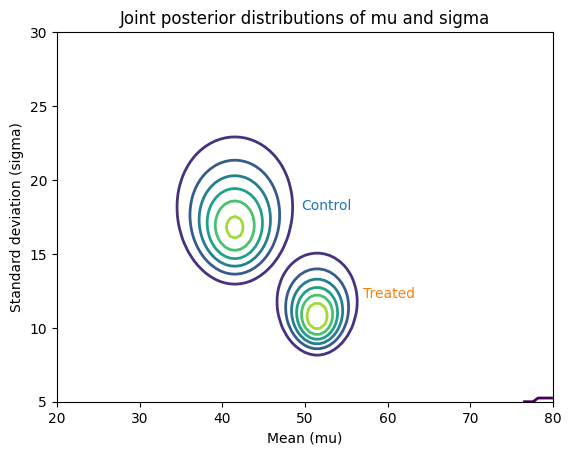

In [26]:
plot_contour(posterior_control, cmap="Blues")
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap="Oranges")
plt.text(57, 12, 'Treated', color='C1')

plt.xlabel("Mean (mu)")
plt.ylabel("Standard deviation (sigma)")
plt.title("Joint posterior distributions of mu and sigma")

In [27]:
# Then we use 'marginal' to calculate posterior marginal distributions for pop means

def marginal(joint, axis):
    """Compute a marginal distribution."""
    return Pmf(joint.sum(axis=axis))

In [28]:
pmf_mean_control = marginal(posterior_control, 0)
pmf_mean_treated = marginal(posterior_treated, 0)

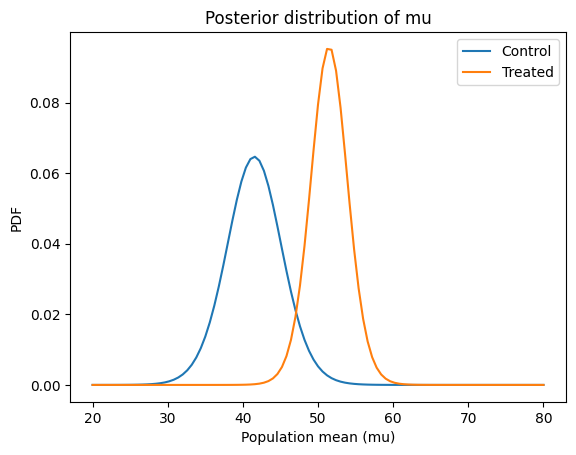

In [31]:
pmf_mean_control.plot(label="Control", xlabel="Population mean (mu)", ylabel="PDF")
pmf_mean_treated.plot(label="Treated", title="Posterior distribution of mu")
plt.legend()

In [32]:
# Posterior probabilities at the ends of the range are near 0, meaning bounds chosen for the prior are wide enough

Pmf.prob_gt(pmf_mean_treated, pmf_mean_control) # 98% chance that the treated group's mean is higher

np.float64(0.980479025187326)

In [33]:
pmf_diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

In [34]:
len(pmf_mean_treated), len(pmf_mean_control), len(pmf_diff)

(101, 101, 879)

<Axes: title={'center': 'Posterior dist of difference in mu'}, xlabel='Difference in means (mu)', ylabel='PDF'>

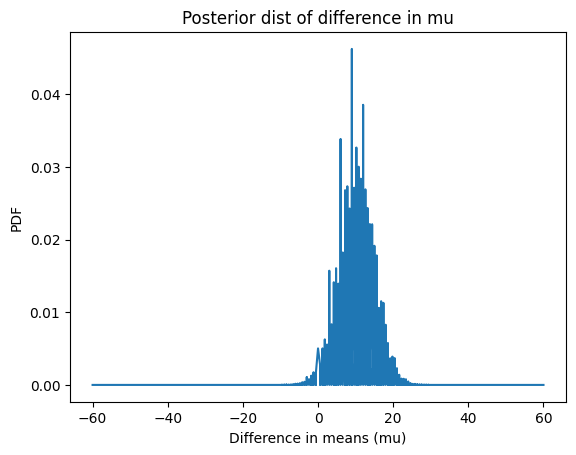

In [35]:
# We can plot the Pmf, but the result can be noisy

pmf_diff.plot(xlabel="Difference in means (mu)", ylabel="PDF", title="Posterior dist of difference in mu")

In [36]:
# Plotting the CDF smooths out the noise

cdf_diff = pmf_diff.make_cdf()

<Axes: title={'center': 'Posterior distribution of difference in mu'}, xlabel='Difference in population means', ylabel='CDF'>

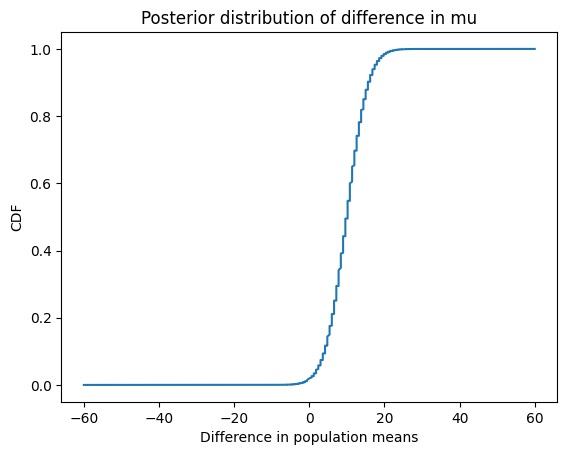

In [37]:
cdf_diff.plot(xlabel="Difference in population means", ylabel="CDF", title="Posterior distribution of difference in mu")

In [38]:
# Can also use KDE to make a smooth approximation of the PDF

from scipy.stats import gaussian_kde

def kde_from_pmf(pmf, n=101):
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [39]:
kde_diff = kde_from_pmf(pmf_diff)

<Axes: title={'center': 'Posterior distribution of difference in mu'}, xlabel='Difference in means', ylabel='PDF'>

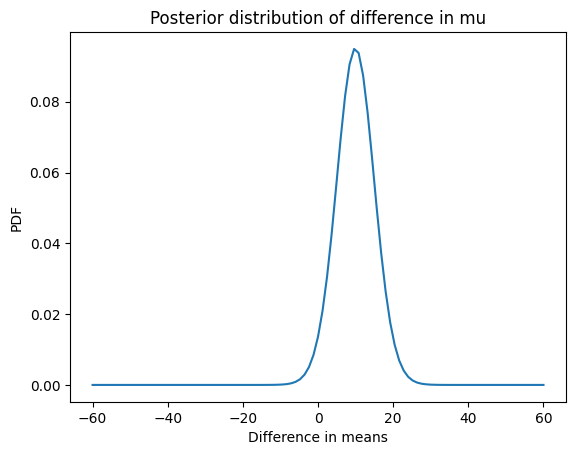

In [40]:
kde_diff.plot(xlabel="Difference in means", ylabel="PDF", title="Posterior distribution of difference in mu")

In [41]:
# The mean of this distribution is ~10 where the mean is ~45, so the treatment effect is large

pmf_diff.mean()

np.float64(9.954413088940848)

In [42]:
pmf_diff.credible_interval(0.9)

array([ 2.4, 17.4])

In [43]:
# This method becomes impractical with very large datasets
# We can also compute a summary of the data and a likelihood of the summary
# If we compute the mean and SD of the data, we can compute their likelihoods under each hypothesis

# Suppose we know the population mean and SD
mu = 42
sigma = 17

# Now we draw a sample from this distribution with n=20, and compute sample versions of these statistics

n = 20
m = 41
s = 18

# Now we compute likelihoods of m and s given mu and sigma

dist_m = norm(m, sigma/np.sqrt(n)) # Normal distribution of mu-hat given known mu and sigma

# This sampling dist can be used to compute the likelihood of observed m

like1 = dist_m.pdf(m)
like1

np.float64(0.10494847742075125)

In [44]:
# Now the likelihood of s=18. 1st we compute the transform statistic t
t = n * s**2 / sigma**2
t

22.422145328719722

In [45]:
from scipy.stats import chi2 # The statistic t is chi-square distributed with n-1

dist_s = chi2(n-1)

like2 = dist_s.pdf(t)
like2

np.float64(0.04736427909437004)

In [46]:
# because m and s are independent, the joint likelihood is their product

like = like1 * like2
like

np.float64(0.004970808975085655)

In [47]:
# Now we update with the summary statistics

summary = {}

for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
    
summary

{'Control': (23,
  np.float64(41.52173913043478),
  np.float64(17.148733229699484)),
 'Treated': (21,
  np.float64(51.476190476190474),
  np.float64(11.00735684721381))}

In [48]:
# So, the update with the control data proceeds as:

n, m, s = summary["Control"]

mus, sigmas = np.meshgrid(prior.columns, prior.index)
mus.shape

(101, 101)

In [49]:
like1 = norm(mus, sigmas/np.sqrt(n)).pdf(m)
like1.shape

(101, 101)

In [50]:
ts = n * s**2 / sigmas**2
like2 = chi2(n-1).pdf(ts)
like2.shape

(101, 101)

In [51]:
posterior_control2 = prior * like1 * like2
normalize(posterior_control2)

np.float64(0.00030965351017402847)

In [52]:
# Doing the update in a function

def update_norm_summary(prior, data):
    n, m, s = data
    mu_mesh, sigma_mesh = np.meshgrid(prior.columns, prior.index)
    
    like1 = norm(mu_mesh, sigma_mesh/np.sqrt(n)).pdf(m)
    like2 = chi2(n-1).pdf(n * s**2 / sigma_mesh**2)
    
    posterior = prior * like1 * like2
    normalize(posterior)
    return posterior

In [53]:
data = summary["Treated"]
posterior_treated2 = update_norm_summary(prior, data)

Text(0, 0.5, 'Standard deviation (sigma)')

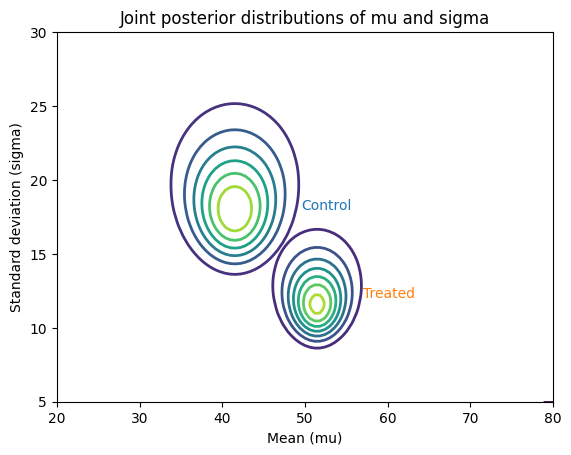

In [54]:
plot_contour(posterior_control2, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated2, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

plt.title("Joint posterior distributions of mu and sigma")
plt.xlabel("Mean (mu)")
plt.ylabel("Standard deviation (sigma)")

In [55]:
pmf_mean_control2 = marginal(posterior_control2, 0)
pmf_mean_treated2 = marginal(posterior_treated2, 0)

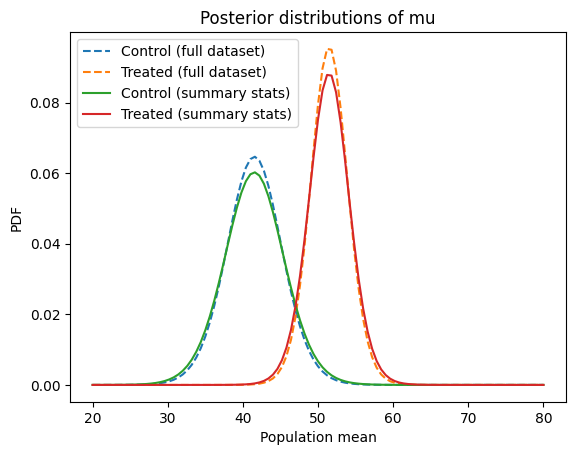

In [57]:
pmf_mean_control.plot(label="Control (full dataset)", title="Posterior distributions of mu", ls="--")
pmf_mean_treated.plot(label="Treated (full dataset)", xlabel="Population mean", ls="--")
pmf_mean_control2.plot(label="Control (summary stats)", ylabel="PDF")
pmf_mean_treated2.plot(label="Treated (summary stats)")
plt.legend()

In [58]:
# Exercise 13-1
# We need the marginal posterior distributions of sigma for the 2 groups

pmf_sigma_control = marginal(posterior_control, 1)
pmf_sigma_treated = marginal(posterior_treated, 1)

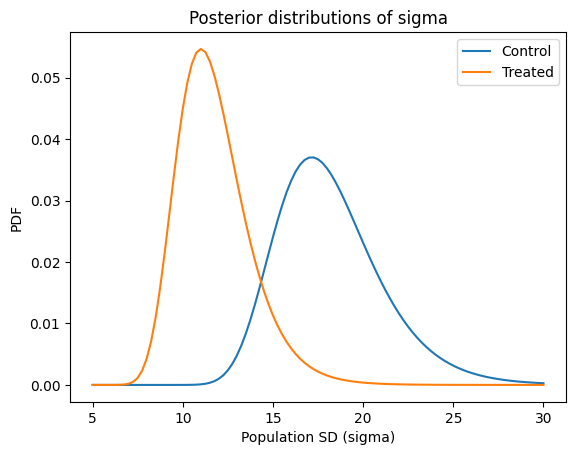

In [59]:
pmf_sigma_control.plot(label='Control', title='Posterior distributions of sigma')
pmf_sigma_treated.plot(label='Treated', xlabel='Population SD (sigma)', ylabel="PDF")
plt.legend()

In [61]:
Pmf.prob_gt(pmf_sigma_control, pmf_sigma_treated) # THIS IS RIGHT

np.float64(0.9685103375300469)

In [62]:
# Distribution of the difference in sigma
# Can I use KDE for a chi-square-distributed variable? Not needed, but apparently so (according to the solution)

pmf_sigma_diff = Pmf.sub_dist(pmf_sigma_control, pmf_sigma_treated)

<Axes: title={'center': 'Posterior dist of difference in sigma'}, xlabel='Difference in SDs (sigma)', ylabel='PDF'>

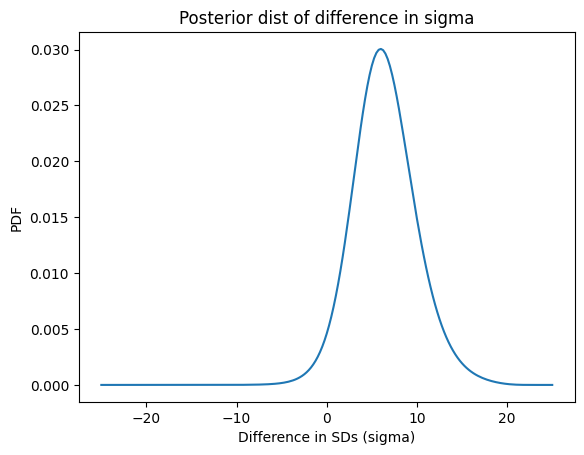

In [63]:
pmf_sigma_diff.plot(xlabel="Difference in SDs (sigma)", ylabel="PDF", title="Posterior dist of difference in sigma")

In [64]:
pmf_sigma_diff.mean() # THIS IS RIGHT!

np.float64(6.41717132817218)

In [65]:
pmf_sigma_diff.credible_interval(0.9) # THIS IS RIGHT!

array([ 1. , 12.5])

In [66]:
# Exercise 13-2 - use joint posterior distributions for Treated and Control to compute a posterior for Cohen's d
# Cohen's d = (mu1 - mu2) / ((sd1 + sd2)/2)

# According to the solution, enumerating all pairs from the 2 posteriors takes too long, so we use random sampling
# The solution provides this function:

def sample_joint(joint, size):
    """Draw a sample from a joint distribution.
    
    joint: DataFrame representing a joint distribution
    size: sample size
    """
    pmf = Pmf(joint.transpose().stack())
    return pmf.choice(size)

In [67]:
# Then we sample pairs from each

sample_treated = sample_joint(posterior_treated, 1000)
sample_treated.shape

(1000,)

In [68]:
sample_control = sample_joint(posterior_control, 1000)

In [70]:
# This creates arrays of tuples, that each contain a pair of possible values for mu and sigma
# We loop through the samples, compute d for each, and estimate distribution of d's

def cohen_d(pair1, pair2):
    """Compute Cohen's effect size for difference in means.
    
    pair1: tuple of (mu1, sigma1)
    pair2: tuple of (mu2, sigma2)
    
    return: float
    """
    mu1, sigma1 = pair1 
    mu2, sigma2 = pair2
    sigma = (sigma1 + sigma2) / 2
    return (mu1 - mu2) / sigma

In [71]:
cohen_d(sample_treated[0], sample_control[0])

0.47368421052631576

In [72]:
ds = []
for pair1, pair2 in zip(sample_treated, sample_control):
    d = cohen_d(pair1, pair2)
    ds.append(d)

In [73]:
cdf = Cdf.from_seq(ds)

<Axes: title={'center': 'Posterior distributions of effect sizes'}, xlabel='Cohen d', ylabel='CDF'>

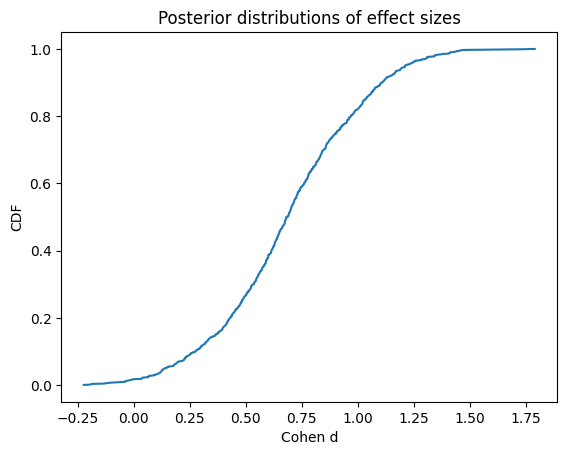

In [74]:
cdf.plot(title='Posterior distributions of effect sizes', xlabel='Cohen d', ylabel='CDF')

In [75]:
print(cdf.mean(), cdf.credible_interval(0.9))

0.690897055013314 [0.13714286 1.21081081]


In [76]:
# Interesting. Not like a typical Bayesian analysis, in that we don't start with a prior and estimate a
# likelihood. You can just derive the posterior of a summary statistic from posteriors of other statistics.

In [77]:
# Exercise 13-3
# Average test score = 81
# N = 25 students
# 5 students scored over 90
# No students scored under 60
# QUESTION: What was the SD of scores?
# ASSUME: Dist of scores is roughly normal, and that mu = m = 81

mu = 81
m = 81
N = 25

In [81]:
# OK, based on the solution, I was not approaching this correctly

# According to the solution, the following prior can be derived by trial and error

hypos = np.linspace(1, 51, 101)

# For each hypothetical sigma, the probabilities of a score > 90 are estimated as follows:

prob_gt90 = norm(81, hypos).sf(90)

# And then the probability that 5/25 people score above 90, which is our likelihood

from scipy.stats import binom

like1 = binom(25, prob_gt90).pmf(5)

In [83]:
# Then we do our update

prior = Pmf(1, hypos)
posterior = prior * like1
posterior.normalize()

np.float64(5.299480018256258)

<Axes: title={'center': 'Posterior distribution of sigma'}, xlabel='SD (sigma)', ylabel='PMF'>

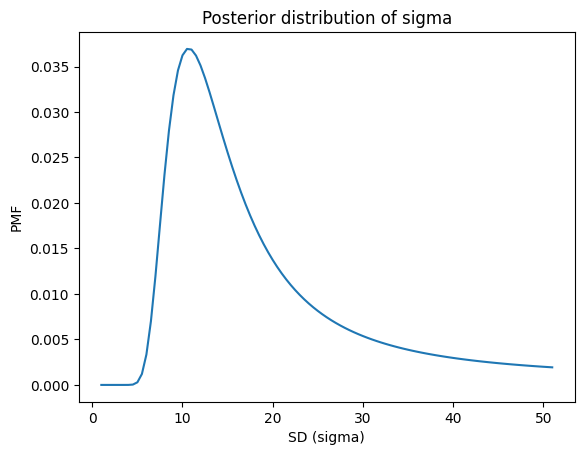

In [85]:
posterior.plot(title="Posterior distribution of sigma", xlabel='SD (sigma)', ylabel="PMF")

In [86]:
# Our 2nd piece of data is that no one scored below 60
# Here is the prob of a score > 60

prob_gt60 = norm(81, hypos).sf(60)

# And the 2nd likelihood, or the prob of all 25 students being above 60

like2 = prob_gt60 ** 25

In [87]:
# The posterior after both updates

prior = Pmf(1, hypos)
prior.normalize()
posterior2 = prior * like1 * like2
posterior2.normalize()

np.float64(0.01425455531129565)

<Axes: title={'center': 'Posterior distribution of sigma with all data'}, xlabel='SD (sigma)', ylabel='PMF'>

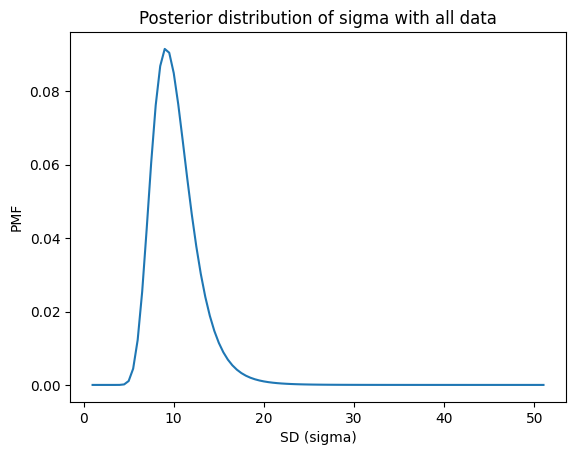

In [88]:
posterior2.plot(title="Posterior distribution of sigma with all data", xlabel='SD (sigma)', ylabel="PMF")

In [89]:
print(posterior2.mean(), posterior2.credible_interval(0.9))

10.189707962198526 [ 7. 15.]


In [90]:
# Exercise 13-4

# Male heights, mean = 178, SD = 8.27, coeff of variation (CV) = 0.0465
# Male N = 154407
# Female heights, mean = 163, SD = 7.75, CV = 0.0475
# Female N = 254722

# Compute posterior distributions of mu and sigma for men and women
# Use pmf.div_dist to compute posteriors for CV
# Assume heights are normally distributed
# Est prob that male CV > female CV
# What is most likely ratios of CVs, 90% cred interval for that ratio?

# Specify priors for mu and sigma, knowing that I'll have to trial-and-error it a bit;
# the prior bounds are wide enough if the posterior probabilities at the edges of the range are near zero

# Priors
# Men

qs_m_m = np.linspace(140, 220, num=101)
prior_mu_m = make_uniform(qs_m_m, name='M mean')

qs_s_m = np.linspace(3, 15, num=101)
prior_sigma_m = make_uniform(qs_s_m, name='M std')

# Women

qs_m_f = np.linspace(120, 200, num=101)
prior_mu_f = make_uniform(qs_m_f, name='F mean')

qs_s_f = np.linspace(3, 15, num=101)
prior_sigma_f = make_uniform(qs_s_f, name='F std')

prior_m = make_joint(prior_mu_m, prior_sigma_m)
prior_f = make_joint(prior_mu_f, prior_sigma_f)

In [96]:
# Likelihood and update for men

n_m = 154407
m_m = 178
s_m = 8.27

mus, sigmas = np.meshgrid(prior_m.index, prior_m.columns)
like1 = norm(mus, sigmas/np.sqrt(n_m)).pdf(m_m)

ts = n_m * s_m**2 / sigmas**2
like2 = chi2(n_m-1).pdf(ts)

posterior_m = prior_m * like1 * like2
normalize(posterior_m)

# Likelihood and update for women

n_f = 254722
m_f = 163
s_f = 7.75

mus, sigmas = np.meshgrid(prior_f.index, prior_f.columns)
like1 = norm(mus, sigmas/np.sqrt(n_f)).pdf(m_f)

ts = n_f * s_f**2 / sigmas**2
like2 = chi2(n_f-1).pdf(ts)

posterior_f = prior_f * like1 * like2
normalize(posterior_f)

np.float64(0.0)

In [98]:
# OK, some good ideas here, but this is the solution
# This function is given by the author

def get_posterior_cv(joint):
    """Get the posterior distribution of CV.
    
    joint: joint distribution of mu and sigma
    
    returns: Pmf representing the smoothed posterior distribution
    """
    pmf_mu = marginal(joint, 0)
    pmf_sigma = marginal(joint, 1)
    pmf_cv = Pmf.div_dist(pmf_sigma, pmf_mu)
    return kde_from_pmf(pmf_cv)

Text(0.5, 1.0, 'Joint distribution of mu and sigma for men')

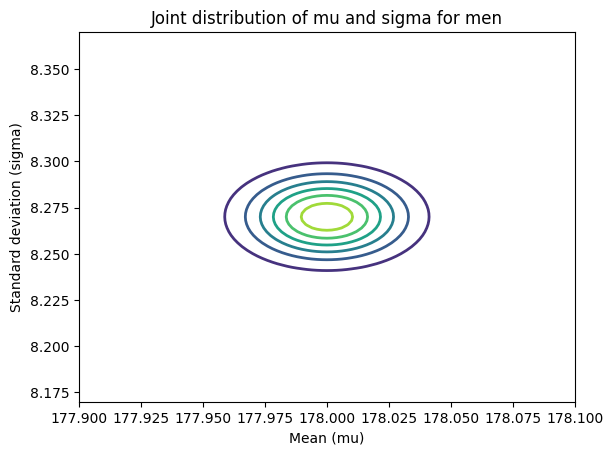

In [99]:
# Estimating posterior for men

n = 154407
mean = 178
std = 8.27

qs = np.linspace(mean-0.1, mean+0.1, num=101)
prior_mu = make_uniform(qs, name='mean')

qs = np.linspace(std-0.1, std+0.1, num=101)
prior_sigma = make_uniform(qs, name='std')

prior = make_joint(prior_mu, prior_sigma)

data = n, mean, std
posterior_m = update_norm_summary(prior, data)

plot_contour(posterior_m, cmap='Blues')
plt.xlabel('Mean (mu)')
plt.ylabel('Standard deviation (sigma)')
plt.title('Joint distribution of mu and sigma for men')


Text(0.5, 1.0, 'Joint distribution of mu and sigma for women')

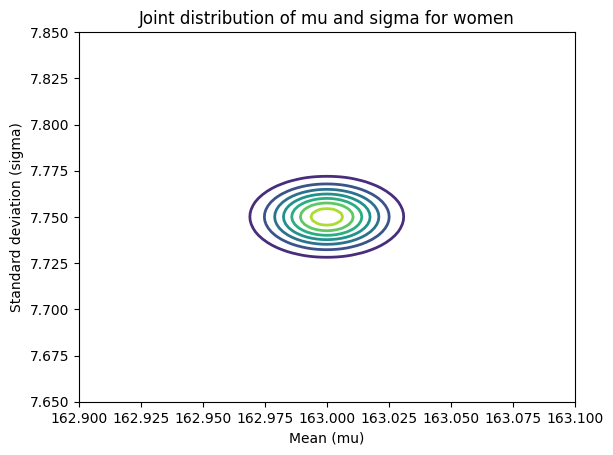

In [100]:
# Estimating posterior for women

n = 254722
mean = 163
std = 7.75

qs = np.linspace(mean-0.1, mean+0.1, num=101)
prior_mu = make_uniform(qs, name='mean')

qs = np.linspace(std-0.1, std+0.1, num=101)
prior_sigma = make_uniform(qs, name='std')

prior = make_joint(prior_mu, prior_sigma)

data = n, mean, std
posterior_f = update_norm_summary(prior, data)

plot_contour(posterior_f, cmap='Oranges')
plt.xlabel('Mean (mu)')
plt.ylabel('Standard deviation (sigma)')
plt.title('Joint distribution of mu and sigma for women')

Text(0.5, 1.0, 'Posterior distributions of CV')

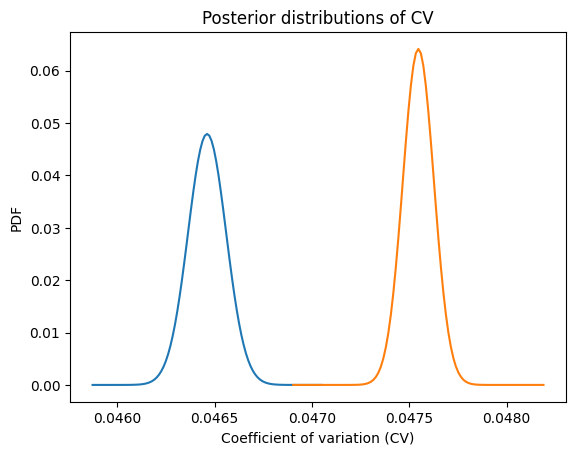

In [103]:
pmf_cv_male = get_posterior_cv(posterior_m)
kde_from_pmf(pmf_cv_male).plot()

pmf_cv_female = get_posterior_cv(posterior_f)
kde_from_pmf(pmf_cv_female).plot()

plt.xlabel('Coefficient of variation (CV)')
plt.ylabel('PDF')
plt.title('Posterior distributions of CV')
#plt.legend()

In [104]:
ratio_cv = Pmf.div_dist(pmf_cv_female, pmf_cv_male)
ratio_cv.max_prob()

np.float64(1.0233615721208176)

In [105]:
ratio_cv.credible_interval(0.9)

array([1.0193799 , 1.02734473])

In [106]:
print(Pmf.prob_gt(pmf_cv_male, pmf_cv_female))

4.9059479214516316e-24
